<a href="https://colab.research.google.com/github/YeralyK/Deep_Learning_Course/blob/main/Bears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install -U fastai ddgs
!pip -q install -U fastprogress==1.0.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.7 MB/s eta 0:00:00


In [2]:
import fastprogress
print("fastprogress:", fastprogress.__version__)

from fastprogress.fastprogress import force_console_behavior
force_console_behavior()

from fastai.vision.all import *
from ddgs import DDGS
import time, random


fastprogress: 1.0.3


In [3]:
ddgs = DDGS()

def search_images_ddg(query, max_results=80):
    """Return a list of image URLs from DuckDuckGo."""
    results = ddgs.images(
        query=query,
        max_results=max_results,
        safesearch="moderate",
        region="wt-wt"
    )
    urls = []
    for r in results:
        u = r.get("image", None)
        if u: urls.append(u)

    # de-duplicate while preserving order
    seen = set()
    uniq = []
    for u in urls:
        if u not in seen:
            uniq.append(u)
            seen.add(u)
    return uniq

def download_class(path, class_name, n=80):
    dest = path/class_name
    dest.mkdir(parents=True, exist_ok=True)

    query = f"{class_name} bear"
    for attempt in range(5):
        try:
            urls = search_images_ddg(query, max_results=n)
            print(f"{class_name}: got {len(urls)} urls")
            if len(urls) == 0:
                time.sleep(2 + attempt)
                continue

            download_images(dest, urls=urls, max_pics=n)
            time.sleep(1.0 + random.random())  # reduce rate-limits
            return
        except Exception as e:
            print(f"{class_name}: attempt {attempt+1} failed:", e)
            time.sleep(2 + attempt)

    print(f"{class_name}: FAILED to download after retries")


In [4]:
path = Path("bears")
path.mkdir(exist_ok=True)

bear_types = ["grizzly", "black", "teddy"]

for b in bear_types:
    download_class(path, b, n=80)

fns = get_image_files(path)
print("Total downloaded images:", len(fns))


grizzly: got 80 urls
black: got 80 urls
teddy: got 80 urls
Total downloaded images: 217


In [5]:
failed = verify_images(fns)
print("Corrupted images:", len(failed))
failed.map(Path.unlink)

fns = get_image_files(path)
print("Images after cleanup:", len(fns))


Corrupted images: 0
Images after cleanup: 217


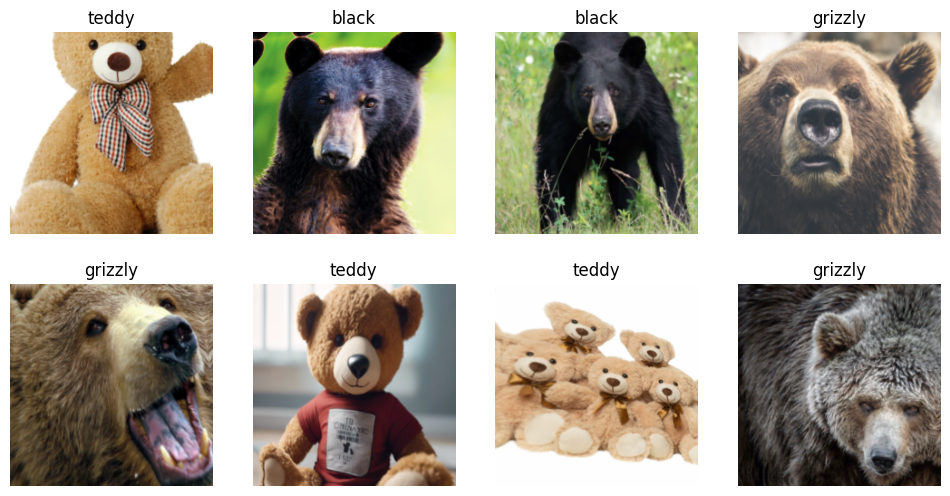

In [6]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = bears.dataloaders(path, bs=32)
dls.train.show_batch(max_n=8, nrows=2)


In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.400428,0.077247,0.000000,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.144317,0.015312,0.000000,00:57
1,0.124782,0.002990,0.000000,00:59
2,0.091298,0.003111,0.000000,01:00
3,0.069418,0.004867,0.000000,00:56


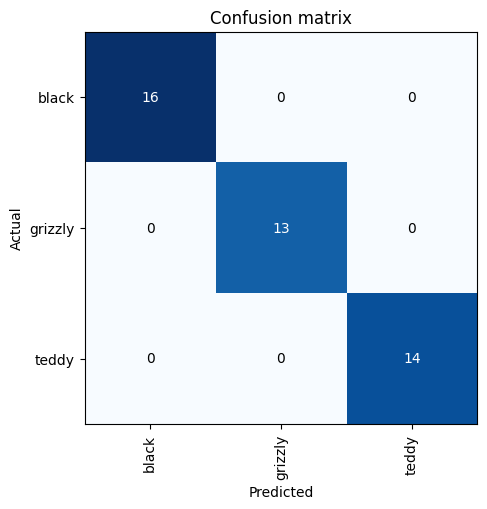

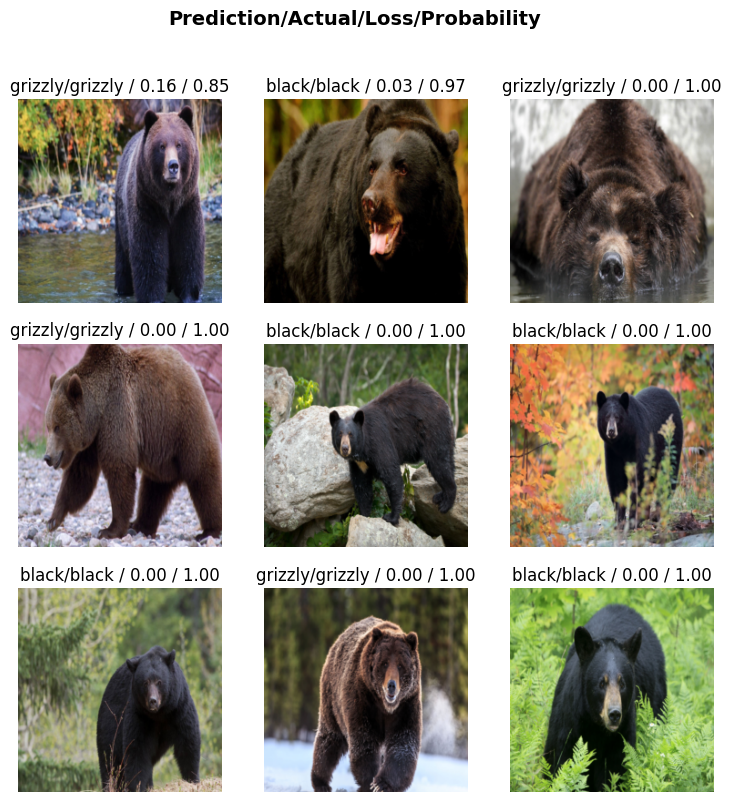

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.plot_top_losses(9, nrows=3)


In [9]:
learn.export("bear_classifier.pkl")

learn_inf = load_learner("bear_classifier.pkl")  # warning is normal (pickle)

test_img = random.choice(fns)
pred, pred_idx, probs = learn_inf.predict(test_img)

print("File:", test_img)
print("Prediction:", pred, "prob:", float(probs[pred_idx]))
print("Classes:", learn_inf.dls.vocab)


/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


File: bears/black/320e1b7d-ebb6-48d2-b3e9-d41774211134.jpg
Prediction: black prob: 0.9999667406082153
Classes: ['black', 'grizzly', 'teddy']
